# Combining OGGM's climate data with ODINN's MB model

In [1]:
## Environment and packages
using Pkg; Pkg.activate("../../."); Pkg.instantiate()

  Activating environment at `~/Desktop/Jordi/Julia/odinn_toy_model/Project.toml`


In [2]:
ENV["PYTHON"] = "/Users/Bolib001/miniconda3/envs/oggm_env/bin/python3.9" # Choose own Python environment with OGGM's installation
using PyCall
Pkg.build("PyCall")

    Building Conda ─→ `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/299304989a5e6473d985212c28928899c74e9421/build.log`
    Building PyCall → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/169bb8ea6b1b143c5cf57df6d34d022a7b60c6db/build.log`


## Import Python OGGM libraries and configure Glacier directories

A call to [cfg.initialize()](https://docs.oggm.org/en/stable/generated/oggm.cfg.initialize.html) will read the default parameter file (or any user-provided file) and make them available to all other OGGM tools via the `cfg.PARAMS` dictionary. Here are some examples of these parameters:

In [3]:
cfg = pyimport("oggm.cfg")
utils = pyimport("oggm.utils")
cfg.initialize()

2021-09-27 17:39:09: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-09-27 17:39:09: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2021-09-27 17:39:09: oggm.cfg: Multiprocessing: using all available processors (N=8)


In [4]:
workflow = pyimport("oggm.workflow")

PyObject <module 'oggm.workflow' from '/Users/Bolib001/Python/oggm/oggm/workflow.py'>

### Whenever we want to modify a field from a class we need to create a Julian instance:

In [5]:
PARAMS = PyDict(cfg."PARAMS")

PyDict{PyAny, PyAny, true} with 107 entries:
  "has_internet"            => true
  "dl_cache_readonly"       => false
  "use_multiprocessing"     => false
  "use_mp_spawn"            => false
  "mp_processes"            => 8
  "lru_maxsize"             => 100
  "continue_on_error"       => false
  "grid_dx_method"          => "square"
  "topo_interp"             => "cubic"
  "use_intersects"          => true
  "use_compression"         => true
  "border"                  => 40
  "mpi_recv_buf_size"       => 131072
  "use_multiple_flowlines"  => true
  "filter_min_slope"        => true
  "auto_skip_task"          => false
  "correct_for_neg_flux"    => true
  "filter_for_neg_flux"     => false
  "run_mb_calibration"      => false
  "rgi_version"             => "62"
  "use_rgi_area"            => true
  "compress_climate_netcdf" => true
  "use_tar_shapefiles"      => true
  "clip_mu_star"            => false
  "clip_tidewater_border"   => true
  ⋮                         => ⋮

In [6]:
PARAMS["prcp_scaling_factor"], PARAMS["ice_density"], PARAMS["continue_on_error"]
PARAMS["use_multiprocessing"] = true # Let's use multiprocessing

2021-09-27 17:39:11: oggm.cfg: Multiprocessing switched ON after user settings.


true

Each OGGM run needs a **single folder** where to store the results of the computations for all glaciers. This is called a "working directory" and needs to be specified before each run.

In [7]:
PATHS = PyDict(cfg."PATHS")

PyDict{PyAny, PyAny, true} with 7 entries:
  "dl_cache_dir" => "/Users/Bolib001/OGGM/download_cache"
  "tmp_dir"      => "/Users/Bolib001/OGGM/tmp"
  "rgi_dir"      => "/Users/Bolib001/OGGM/rgi"
  "test_dir"     => "/Users/Bolib001/OGGM/tests"
  "working_dir"  => ""
  "dem_file"     => ""
  "climate_file" => ""

In [8]:
PATHS["working_dir"] = "/Users/Bolib001/Jordi/Python/OGGM_data"

"/Users/Bolib001/Jordi/Python/OGGM_data"

**This working directory is meant to be persistent**, i.e. you can stop your processing workflow after any task, and restart from an existing working directory at a later stage.

### Define the glaciers for the run 

In [9]:
rgi_ids = ["RGI60-11.01450"]

1-element Vector{String}:
 "RGI60-11.01450"

### Glacier directories 

The OGGM workflow is organized as a list of **tasks** that have to be applied to a list of glaciers. The vast majority of tasks are called **entity tasks**: they are standalone operations to be realized on one single glacier entity. These tasks are executed sequentially (one after another): they often need input generated by the previous task(s): for example, the climate calibration needs the glacier flowlines, which can be only computed after the topography data has been processed, and so on.

To handle this situation, OGGM uses a workflow based on data persistence on disk: instead of passing data as python variables from one task to another, each task will read the data from disk and then write the computation results back to the disk, making these new data available for the next task in the queue.

These glacier specific data are located in [glacier directories](https://docs.oggm.org/en/stable/glacierdir.html#glacier-directories). In the model, these directories are initialized with the following command (this can take a little while on the first call, as OGGM needs to download some data):

In [10]:
# Where to fetch the pre-processed directories
gdirs = workflow.init_glacier_directories(rgi_ids, from_prepro_level=3, prepro_border=80)
gdir = gdirs[1]
println("Path to the DEM:", gdir.get_filepath("dem"))

Path to the DEM:/Users/Bolib001/Jordi/Python/OGGM_data/per_glacier/RGI60-11/RGI60-11.01/RGI60-11.01450/dem.tif


2021-09-27 17:39:13: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2021-09-27 17:39:13: oggm.workflow: Execute entity task gdir_from_prepro on 1 glaciers
2021-09-27 17:39:13: oggm.utils: /Users/Bolib001/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/L3-L5_files/CRU/centerlines/qc3/pcp2.5/no_match/RGI62/b_080/L3/RGI60-11/RGI60-11.01.tar verified successfully.


In [11]:
using PyPlot
graphics = pyimport("oggm.graphics")
plt = pyimport("matplotlib.pyplot")

PyObject <module 'matplotlib.pyplot' from '/Users/Bolib001/miniconda3/envs/oggm_env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

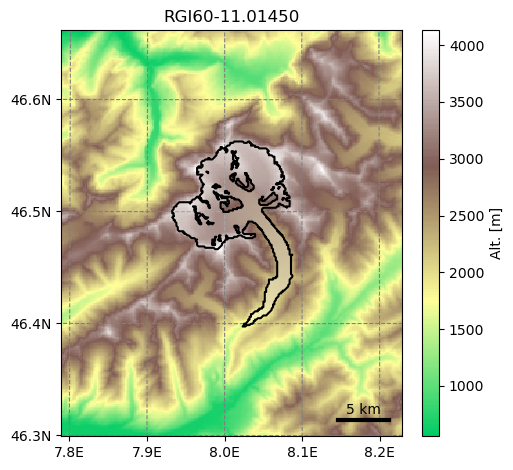

In [12]:
graphics.plot_domain(gdirs)

Another advantage of glacier directories is their persistence on disk: once created, **they can be recovered from the same location** by using `init_glacier_directories` again, but without keyword arguments:

In [13]:
# Fetch the LOCAL pre-processed directories - note that no arguments are used!
gdirs = workflow.init_glacier_directories(rgi_ids)

2021-09-27 17:39:22: oggm.workflow: Execute entity task GlacierDirectory on 1 glaciers


1-element Vector{PyObject}:
 PyObject <oggm.GlacierDirectory>
  RGI id: RGI60-11.01450
  Region: 11: Central Europe
  Subregion: 11-01: Alps                            
  Glacier type: Glacier
  Terminus type: Land-terminating
  Status: Glacier or ice cap
  Area: 82.206 km2
  Lon, Lat: (8.01919, 46.5028)
  Grid (nx, ny): (247, 294)
  Grid (dx, dy): (137.0, -137.0)


### Climate tasks 

The glacier directories we downloaded already contains the climate timeseries for each glacier (`from_prepro_level=3`). Let's have a look at them:

In [14]:
# xr = pyimport("xarray")
# np = pyimport("numpy")
# fpath = gdir.get_filepath("climate_historical")
# ds = xr.open_dataset(fpath)

# # Functions to get slices of PyObjects
# slice_idx(idx) = pycall(pybuiltin("slice"), PyObject, idx[1],idx[2])
# sl(pyo,idx) = get(pyo, slice_idx(idx))

# # Data is in hydrological years
# # -> let's just ignore the first and last calendar years
# # sl(ds.temp.resample(time="AS").mean(), (1,-1)).plot() # Keeping the DataArray object (with Pythonic indexes)
# plot(ds.temp.resample(time="AS").mean().to_numpy()[2:end-1]) # Converting to numpy and plotting afterwards (with Julian indexes)


In [22]:
using ClimateBase

fpath = gdir.get_filepath("climate_historical")
# file = NCDataset(fpath)
ds = ncread(fpath)


LoadError: MethodError: no method matching ncread(::NCDataset{Nothing})
[0mClosest candidates are:
[0m  ncread(::NCDatasets.AbstractDataset, [91m::Any[39m; name, grid, lon, lat) at /Users/Bolib001/.julia/packages/ClimateBase/HXqDN/src/core/nc_io.jl:119
[0m  ncread([91m::Union{String, Vector{String}}[39m, [91m::Any...[39m; kwargs...) at /Users/Bolib001/.julia/packages/ClimateBase/HXqDN/src/core/nc_io.jl:104

In [ ]:
fpath

This climate data is called the "baseline climate" for this glacier. It will be used for the mass-balance model calibration, and at the end of this tutorial also to generate the random climate to drive a simulation. When running OGGM with GCM data, the GCM timeseries will be computed as anomalies to this baseline timeseries, hence the name.

Here we are using CRU, but OGGM-Shop also allows to use ERA5 and CERA as baseline.

In [ ]:
gdirs[1]

In [ ]:
# Get the reference mass-balance from the WGMS
ref_MB = gdirs[1].get_ref_mb_data()

## Train simple temperature-index MB model from ODINN using OGGM glacier directories

We import the simple ODINN MB model

In [ ]:
include("../mass_balance.jl")

In [ ]:
range_Ut(x) = min(max(3, x), 12)
range_Up(x) = min(max(1, x), 3)

# Temperature-index equation for point glacier mass balance
function MB(P, T, Up, Ut)
    Ut = range_Ut(Ut)
    Up = range_Up(Up)
    T_melt = 0
    MB = P.*Up - max.(T.-T_melt, 0).*Ut
    return MB
end

In [ ]:
# ds.temp.resample(time="MS")
ds.temp.sel(time=slice(string(ref_MB.index[1])*"-01-01", string(ref_MB.index[end])*"-01-01"))


In [ ]:
slice(ds.temp.resample(time="AS").mean(), (1,-1))

In [ ]:
ref_MB["WINTER_BALANCE"]

# X = vcat(snowfall_toy', temperature_toy')
# Y = collect(MB_toy')

# # Very important:
# # Shuffle batches and use batchsize similar to dataset size for easy training
# data = Flux.Data.DataLoader((X, Y), batchsize=hyparams.batchsize, (X, Y), shuffle=true)